# Advanced Methods of Bioinformatics Project
## Reimplementation of "Spectrum: fast density-aware spectral clustering for single and multi-omic data"
### Loïc Cordeiro Fonseca (ULB) and Steen Elliot Sodemann (VUB)

# Import statements

In [ ]:
!pip install scikit-survival

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from google.colab import files
from sklearn.neighbors import kneighbors_graph
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs, make_circles, make_moons
from sksurv.linear_model import CoxPHSurvivalAnalysis
from scipy.linalg import eigh
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import io
import time

In [ ]:
!pip install diptest
import diptest

In [ ]:
!pip install umap-learn scikit-learn
!pip install umap-learn[plot]
import umap
import umap.plot

In [ ]:
!pip install wget
import wget
import tarfile
import os

# Spectrum Algorithm


## Adaptive density-aware kernel


In [ ]:
def adaptive_kernel(X, P, S=7):
  dists = pairwise_distances(X, metric='euclidean')

  nn_P = NearestNeighbors(n_neighbors=P+1).fit(X)
  distances_P, indices_P = nn_P.kneighbors(X) #Determine the P-nearest neighbours for sigma calculation

  sigmas = distances_P[:,-1] #Compute sigma for each point based on P-nearest neighbour

  nn_S = NearestNeighbors(n_neighbors=S+1).fit(X)
  _, indices_S = nn_S.kneighbors(X) #Determine the S-nearest neighbours for CNN calculation
  indices_S = indices_S[:, 1:] #remove the point itself from indices_S

  cnn = np.zeros((X.shape[0], X.shape[0]), dtype = int) #calculate the CNN for each pair of points
  for i in range(X.shape[0]):
    set_i = set(indices_S[i])
    for j in range(i+1, X.shape[0]):
      set_j = set(indices_S[j])
      cnn[i, j] = cnn[j, i] = len(set_i.intersection(set_j))

  A = np.zeros_like(dists) #Calculate A for each pair of points
  for i in range(X.shape[0]):
    for j in range(X.shape[0]):
      A[i, j] = np.exp(-dists[i,j]**2 / (sigmas[i] * sigmas[j] * (cnn[i, j] + 1)))

  return A

## Combining multi-view data and TPG diffusion

In [ ]:
def tpg_diffusion(A_matrices, iters, Z):

  if len(A_matrices) > 1:
    A_combined = np.zeros_like(A_matrices[0])

    for array in A_matrices: #Combine the similarity matrices from Y into a new array
      A_combined += array
  else:
    A_combined = A_matrices

  neighbors = NearestNeighbors(n_neighbors=Z+1).fit(A_combined)
  distances, indices = neighbors.kneighbors(A_combined)
  indices = indices[:,1:]

  A_sparsified = np.zeros_like(A_combined)
  for i in range(A_sparsified.shape[0]):
    for j in indices[i]:
      A_sparsified[i,j] = A_combined[i,j]

  row_sum = A_sparsified.sum(axis = 1, keepdims = True)
  A_normalised = A_sparsified/row_sum #Row normalise A

  Q = A_normalised #Initialise Q to be the normalised A
  I = np.eye(A_normalised.shape[0])

  for _ in range(2, iters+1):
    Q = A_normalised @ Q @ A_normalised.T + I #Iteratively calculate Q

  A_star = Q.T #Transpose Q
  return A_star

## Spectral clustering of similarity matrix

In [ ]:
def spectral_clustering(A_star, k_star=None):

  D = np.diag(1 / np.sqrt(A_star.sum(axis=1)))
  L = D @ A_star @ D

  eigenvals, eigenvects = eigh(L) #Calculate eigen values and eigenvectors of L

  if k_star is None: #Find the optimal number of clusters k*
    eigengaps = np.diff(eigenvals)
    k_star = np.argmax(eigengaps[1:]) + 2

  X = eigenvects[:, :k_star] #Create a matrix by stacking the eigenvectors up to k* in columns

  Y = X / np.linalg.norm(X, axis = 1, keepdims = True) #Row normalise X

  GMM = GaussianMixture(n_components = k_star, random_state = 42) #Use built in Gaussian Mixture function to determing the GMM
  GMM.fit(Y)
  labels = GMM.predict(Y)

  return labels, k_star #return the labels and the number of clusters k*

## Find last substantial drop in multimodality

In [ ]:
def last_substantial_drop(D, f=2, c_max = 7):
  d_min = D[0] #Set d_min to be the first element of D
  c = 1 #Initialise the counter c=1
  K = 2 #Initialise K to be 2
  for i in range(2, len(D)): #Iterate from 3 to (maxK - 1)
    if d_min/f > D[i]: #Check if d_min > f
      d_min = D[i] #Set new d_min
      c = 1 #Reset c to be 1
      K = i+1
    else:
      c += 1
    if c > c_max:
      break
  return K #Return the optimal number of classes K

## Spectrum

In [ ]:
def dip_test(V): #A function to calculate diptest statistic Z
  dips = []

  for vect in V:
    dip = diptest.dipstat(vect) #calculate the diptest statistic Z
    dips.append(dip)

  return dips

def optimal_kernel(X, maxK): #A function to tune P to find the optimal kernel A*
  D_min = []
  for i in range(1, 11): #loop from P=1 to 10 and see which kernel is optimal
    A_i = adaptive_kernel(X, P=i)
    D = np.diag(1 / np.sqrt(A_i.sum(axis=1)))
    L_i = D @ A_i @ D
    eigenvals, eigenvects = eigh(L_i)
    eigenvals = eigenvals[::-1]
    eigenvects = eigenvects[:, ::-1]
    Z_i = dip_test(eigenvects[:,:maxK])
    D_i = np.diff(Z_i)
    D_min.append(np.min(D_i))

  optimal_P = np.argmin(D_min) + 1
  A_star = adaptive_kernel(X, optimal_P)
  return A_star

def Spectrum(X, Z, iters, maxK=10):

  if (1 < len(X) < 5): #if we have multi-omic data we must calculate the optimal kernel for each seperately then combine then
    A_matrices = []
    for i in range(0, len(X)):
      A_optimal_i = optimal_kernel(X[i].T, maxK)
      A_matrices.append(A_optimal_i)
    A_matrices = np.array(A_matrices)
    A_optimal = np.zeros_like(A_matrices[0])
    for matrix in A_matrices:
      A_optimal += matrix
  else:
    A_optimal = optimal_kernel(X, maxK)
  print(A_optimal.shape)
  A_knn = kneighbors_graph(A_optimal, n_neighbors=Z, mode='connectivity', include_self=False).toarray() * A_optimal #sparsify A

  row_sum = A_knn.sum(axis = 1, keepdims = True)
  A_normalised = A_knn/row_sum #Row normalise A

  Q = A_normalised #Initialise Q to be the normalised A
  I = np.eye(A_normalised.shape[0])

  for _ in range(2, iters+1):
    Q = A_normalised @ Q @ A_normalised.T + I #Iteratively calculate Q

  A_final = Q.T
  D = np.diag(1 / np.sqrt(A_final.sum(axis=1)))
  L = D @ A_final @ D #calculate graph Laplacian
  eigenvals, eigenvects = eigh(L) #Eigendecomposition

  eigenvals = eigenvals[::-1] #reverse the order as python sorts in ascending instead of descending order
  eigenvects = eigenvects[:, ::-1]

  Z_dip = dip_test(eigenvects[:,:maxK].T) #calculate dip test statistic
  Diff = np.diff(Z_dip) #calculate difference matrix

  K = last_substantial_drop(Diff)
  X_eigenvects = eigenvects[:,:K] #Create a matrix by stacking the eigenvectors up to k* in columns
  Y = X_eigenvects / np.linalg.norm(X_eigenvects, axis = 1, keepdims = True) #Row normalise X

  GMM = GaussianMixture(n_components = K, random_state = 42) #Use built in Gaussian Mixture function to determing the GMM
  GMM.fit(Y)
  labels = GMM.predict(Y)

  return labels, K, D, eigenvals, A_final

# Getting the data

## Multi-omic TGCA datasets
As a note: the links have all been manually checked to be yield the same datasets used by the article authors.

### Download links for multi-omic datasets

In [ ]:
# Bladder urothelial carcinoma (BLCA) - bladder
bladder_links = ["https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/BLCA/20160128/gdac.broadinstitute.org_BLCA.Merge_mirnaseq__illuminahiseq_mirnaseq__bcgsc_ca__Level_3__miR_gene_expression__data.Level_3.2016012800.0.0.tar.gz" \
                 , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/BLCA/20160128/gdac.broadinstitute.org_BLCA.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes__data.Level_3.2016012800.0.0.tar.gz" \
                 , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/BLCA/20160128/gdac.broadinstitute.org_BLCA.Merge_protein_exp__mda_rppa_core__mdanderson_org__Level_3__protein_normalization__data.Level_3.2016012800.0.0.tar.gz" \
                 , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/BLCA/20160128/gdac.broadinstitute.org_BLCA.Clinical_Pick_Tier1.Level_4.2016012800.0.0.tar.gz"]
# Breast invasive carcinoma (BRCA) - breast
breast_links = ["https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/BRCA/20160128/gdac.broadinstitute.org_BRCA.Merge_mirnaseq__illuminahiseq_mirnaseq__bcgsc_ca__Level_3__miR_gene_expression__data.Level_3.2016012800.0.0.tar.gz" \
                , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/BRCA/20160128/gdac.broadinstitute.org_BRCA.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2016012800.0.0.tar.gz" \
                , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/BRCA/20160128/gdac.broadinstitute.org_BRCA.Merge_protein_exp__mda_rppa_core__mdanderson_org__Level_3__protein_normalization__data.Level_3.2016012800.0.0.tar.gz" \
                , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/BRCA/20160128/gdac.broadinstitute.org_BRCA.Clinical_Pick_Tier1.Level_4.2016012800.0.0.tar.gz"]
# Brain Lower Grade Glioma (LGG) - brainlower
brainlower_links = ["https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/LGG/20160128/gdac.broadinstitute.org_LGG.Merge_mirnaseq__illuminahiseq_mirnaseq__bcgsc_ca__Level_3__miR_gene_expression__data.Level_3.2016012800.0.0.tar.gz" \
                    , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/LGG/20160128/gdac.broadinstitute.org_LGG.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2016012800.0.0.tar.gz" \
                    , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/LGG/20160128/gdac.broadinstitute.org_LGG.Merge_protein_exp__mda_rppa_core__mdanderson_org__Level_3__protein_normalization__data.Level_3.2016012800.0.0.tar.gz" \
                    , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/LGG/20160128/gdac.broadinstitute.org_LGG.Clinical_Pick_Tier1.Level_4.2016012800.0.0.tar.gz"]
# Kidney renal clear cell carcinoma (KIRC) - kidney
kidney_links = ["https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/KIRC/20160128/gdac.broadinstitute.org_KIRC.Merge_mirnaseq__illuminahiseq_mirnaseq__bcgsc_ca__Level_3__miR_gene_expression__data.Level_3.2016012800.0.0.tar.gz" \
                , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/KIRC/20160128/gdac.broadinstitute.org_KIRC.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2016012800.0.0.tar.gz" \
                , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/KIRC/20160128/gdac.broadinstitute.org_KIRC.Merge_protein_exp__mda_rppa_core__mdanderson_org__Level_3__protein_normalization__data.Level_3.2016012800.0.0.tar.gz" \
                , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/KIRC/20160128/gdac.broadinstitute.org_KIRC.Clinical_Pick_Tier1.Level_4.2016012800.0.0.tar.gz"]
# Pheochromocytoma and Paraganglioma (PCPG) - pcpg
pcpg_links = ["https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/PCPG/20160128/gdac.broadinstitute.org_PCPG.Merge_mirnaseq__illuminahiseq_mirnaseq__bcgsc_ca__Level_3__miR_gene_expression__data.Level_3.2016012800.0.0.tar.gz" \
              , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/PCPG/20160128/gdac.broadinstitute.org_PCPG.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2016012800.0.0.tar.gz" \
              , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/PCPG/20160128/gdac.broadinstitute.org_PCPG.Merge_protein_exp__mda_rppa_core__mdanderson_org__Level_3__protein_normalization__data.Level_3.2016012800.0.0.tar.gz" \
              , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/PCPG/20160128/gdac.broadinstitute.org_PCPG.Clinical_Pick_Tier1.Level_4.2016012800.0.0.tar.gz"]
# Skin Cutaneous Melanoma (SKCM) - skcm
skcm_links = ["https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/SKCM/20160128/gdac.broadinstitute.org_SKCM.Merge_mirnaseq__illuminahiseq_mirnaseq__bcgsc_ca__Level_3__miR_gene_expression__data.Level_3.2016012800.0.0.tar.gz" \
, "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/SKCM/20160128/gdac.broadinstitute.org_SKCM.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2016012800.0.0.tar.gz" \
, "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/SKCM/20160128/gdac.broadinstitute.org_SKCM.Merge_protein_exp__mda_rppa_core__mdanderson_org__Level_3__protein_normalization__data.Level_3.2016012800.0.0.tar.gz" \
, "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/SKCM/20160128/gdac.broadinstitute.org_SKCM.Clinical_Pick_Tier1.Level_4.2016012800.0.0.tar.gz"]
# Thyroid carcinoma (THCA) - thyroid
thyroid_links = ["https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/THCA/20160128/gdac.broadinstitute.org_THCA.Merge_mirnaseq__illuminahiseq_mirnaseq__bcgsc_ca__Level_3__miR_gene_expression__data.Level_3.2016012800.0.0.tar.gz" \
                 , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/THCA/20160128/gdac.broadinstitute.org_THCA.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2016012800.0.0.tar.gz" \
                 , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/THCA/20160128/gdac.broadinstitute.org_THCA.Merge_protein_exp__mda_rppa_core__mdanderson_org__Level_3__protein_normalization__data.Level_3.2016012800.0.0.tar.gz" \
                 , "https://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/THCA/20160128/gdac.broadinstitute.org_THCA.Clinical_Pick_Tier1.Level_4.2016012800.0.0.tar.gz"]
# For ease of use
links_dict = {"BLCA":bladder_links,"BRCA":breast_links,"LGG":brainlower_links,"KIRC":kidney_links,"PCPG":pcpg_links,"SKCM":skcm_links,"THCA":thyroid_links}

### Download and prepare dataset

In [ ]:
def get_multi_omic_data(data_type, links):
  directory = f"data/{data_type}"
  try: os.mkdir(directory)
  except: pass
  # Handle multi-omic tgca dataset
  for url in links:
    filename = wget.download(url)
    file = tarfile.open(filename)
    file_content = file.getnames()
    for file_path in file_content:
      data_folder = file_path.split('/')[0]
      file_name = file_path.split('/')[1]
      if file_name.split('.')[0] == data_type:
        file.extract(file_path, 'sample_data/') # Extract data and rename file to something more practical
        data_platform = file_name.split('.')[1].split('_')[0]
        os.rename(f"sample_data/{file_path}",f"{directory}/{data_type}_{data_platform}.data.txt")
        os.rmdir(f"sample_data/{data_folder}/")
    file.close()
    os.remove(filename)

In [ ]:
# import shutil
# shutil.rmtree('data', ignore_errors=True)

In [ ]:
try: os.mkdir("data")
except: pass
data = {}
for link_key in links_dict:
  get_multi_omic_data(link_key, links_dict[link_key])

## Shallow data exploration

In [ ]:
# About TGCA Barcodes: https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/
def split_join_tgcaid(string, keep=4):  # This function is also needed for preprocessing!
  return "-".join(string.split('-')[:keep]) # Keep first 4 elements by default, because of participants with multiple samples
vect_split_join = np.vectorize(split_join_tgcaid)

def read_file(type):
  df_mirna = pd.read_csv(f"data/{type}/{type}_mirnaseq.data.txt", sep='\t', index_col=0)
  df_rna = pd.read_csv(f"data/{type}/{type}_rnaseqv2.data.txt", sep='\t', index_col=0)
  df_prot = pd.read_csv(f"data/{type}/{type}_protein.data.txt", sep='\t', index_col=0)
  df_clin = pd.read_csv(f"data/{type}/{type}_clin.data.txt", sep='\t', index_col=0)
  return (df_mirna, df_rna, df_prot, df_clin)

In [ ]:
dfs = read_file("BLCA")

<ipython-input-13-9f4e626960f5>:7: DtypeWarning: Columns (1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23,25,26,28,29,31,32,34,35,37,38,40,41,43,44,46,47,49,50,52,53,55,56,58,59,61,62,64,65,67,68,70,71,73,74,76,77,79,80,82,83,85,86,88,89,91,92,94,95,97,98,100,101,103,104,106,107,109,110,112,113,115,116,118,119,121,122,124,125,127,128,130,131,133,134,136,137,139,140,142,143,145,146,148,149,151,152,154,155,157,158,160,161,163,164,166,167,169,170,172,173,175,176,178,179,181,182,184,185,187,188,190,191,193,194,196,197,199,200,202,203,205,206,208,209,211,212,214,215,217,218,220,221,223,224,226,227,229,230,232,233,235,236,238,239,241,242,244,245,247,248,250,251,253,254,256,257,259,260,262,263,265,266,268,269,271,272,274,275,277,278,280,281,283,284,286,287,289,290,292,293,295,296,298,299,301,302,304,305,307,308,310,311,313,314,316,317,319,320,322,323,325,326,328,329,331,332,334,335,337,338,340,341,343,344,346,347,349,350,352,353,355,356,358,359,361,362,364,365,367,368,370,371,373,374,376,377,379,38

In [ ]:
dfs[0]

,TCGA-2F-A9KO-01A-11R-A38M-13,TCGA-2F-A9KO-01A-11R-A38M-13.1,TCGA-2F-A9KO-01A-11R-A38M-13.2,TCGA-2F-A9KP-01A-11R-A38M-13,TCGA-2F-A9KP-01A-11R-A38M-13.1,TCGA-2F-A9KP-01A-11R-A38M-13.2,TCGA-2F-A9KQ-01A-11R-A38M-13,TCGA-2F-A9KQ-01A-11R-A38M-13.1,TCGA-2F-A9KQ-01A-11R-A38M-13.2,TCGA-2F-A9KR-01A-11R-A38M-13,...,TCGA-ZF-AA58-01A-12R-A42V-13.2,TCGA-ZF-AA5H-01A-11R-A39B-13,TCGA-ZF-AA5H-01A-11R-A39B-13.1,TCGA-ZF-AA5H-01A-11R-A39B-13.2,TCGA-ZF-AA5N-01A-11R-A42V-13,TCGA-ZF-AA5N-01A-11R-A42V-13.1,TCGA-ZF-AA5N-01A-11R-A42V-13.2,TCGA-ZF-AA5P-01A-11R-A39B-13,TCGA-ZF-AA5P-01A-11R-A39B-13.1,TCGA-ZF-AA5P-01A-11R-A39B-13.2
Hybridization REF,,,,,,,,,,,,,,,,,,,,,
miRNA_ID,read_count,reads_per_million_miRNA_mapped,cross-mapped,read_count,reads_per_million_miRNA_mapped,cross-mapped,read_count,reads_per_million_miRNA_mapped,cross-mapped,read_count,...,cross-mapped,read_count,reads_per_million_miRNA_mapped,cross-mapped,read_count,reads_per_million_miRNA_mapped,cross-mapped,read_count,reads_per_million_miRNA_mapped,cross-mapped
hsa-let-7a-1,20140,5142.198119,N,19131,7326.440788,N,37315,8018.332037,N,100347,...,N,10635,3640.528686,N,11876,5926.819056,N,21683,2343.727537,N
hsa-let-7a-2,40107,10240.225419,Y,38407,14708.411027,N,74430,15993.687618,N,200704,...,Y,20755,7104.764728,N,23307,11631.557068,N,43065,4654.919817,N
hsa-let-7a-3,20445,5220.071526,N,19520,7475.412900,N,37463,8050.134613,N,100844,...,N,10619,3635.051633,N,12191,6084.022492,N,21653,2340.484821,N
hsa-let-7b,32084,8191.771819,N,26256,10055.043089,N,43426,9331.477610,N,134503,...,N,18239,6243.498139,N,33110,16523.827799,N,31239,3376.640896,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-mir-95,2,0.510645,N,7,2.680732,N,3,0.644647,N,13,...,N,2,0.684632,N,40,19.962341,N,13,1.405177,N
hsa-mir-96,116,29.617427,N,77,29.488053,N,333,71.555797,N,586,...,N,214,73.255584,N,159,79.350306,N,26,2.810354,N
hsa-mir-98,285,72.766955,N,336,128.67514,N,361,77.572501,N,420,...,N,176,60.247583,N,184,91.826769,N,246,26.590277,N


In [ ]:
np.unique(vect_split_join(dfs[0].index[1:],2))

array(['hsa-let', 'hsa-mir'], dtype='<U7')

In [ ]:
dfs[1]

,TCGA-2F-A9KO-01A-11R-A38B-07,TCGA-2F-A9KO-01A-11R-A38B-07.1,TCGA-2F-A9KO-01A-11R-A38B-07.2,TCGA-2F-A9KP-01A-11R-A38B-07,TCGA-2F-A9KP-01A-11R-A38B-07.1,TCGA-2F-A9KP-01A-11R-A38B-07.2,TCGA-2F-A9KQ-01A-11R-A38B-07,TCGA-2F-A9KQ-01A-11R-A38B-07.1,TCGA-2F-A9KQ-01A-11R-A38B-07.2,TCGA-2F-A9KR-01A-11R-A38B-07,...,TCGA-ZF-AA58-01A-12R-A42T-07.2,TCGA-ZF-AA5H-01A-11R-A39I-07,TCGA-ZF-AA5H-01A-11R-A39I-07.1,TCGA-ZF-AA5H-01A-11R-A39I-07.2,TCGA-ZF-AA5N-01A-11R-A42T-07,TCGA-ZF-AA5N-01A-11R-A42T-07.1,TCGA-ZF-AA5N-01A-11R-A42T-07.2,TCGA-ZF-AA5P-01A-11R-A39I-07,TCGA-ZF-AA5P-01A-11R-A39I-07.1,TCGA-ZF-AA5P-01A-11R-A39I-07.2
Hybridization REF,,,,,,,,,,,,,,,,,,,,,
gene_id,raw_count,scaled_estimate,transcript_id,raw_count,scaled_estimate,transcript_id,raw_count,scaled_estimate,transcript_id,raw_count,...,transcript_id,raw_count,scaled_estimate,transcript_id,raw_count,scaled_estimate,transcript_id,raw_count,scaled_estimate,transcript_id
?|100130426,0.00,0,uc011lsn.1,0.00,0,uc011lsn.1,0.00,0,uc011lsn.1,0.00,...,uc011lsn.1,0.00,0,uc011lsn.1,1.00,3.17044982830546e-07,uc011lsn.1,0.00,0,uc011lsn.1
?|100133144,35.05,1.41802648386706e-06,"uc010unu.1,uc010uoa.1",38.78,1.21323119521612e-06,"uc010unu.1,uc010uoa.1",28.76,9.11020832753757e-07,"uc010unu.1,uc010uoa.1",32.33,...,"uc010unu.1,uc010uoa.1",10.48,2.40522155549343e-07,"uc010unu.1,uc010uoa.1",0.00,0,"uc010unu.1,uc010uoa.1",12.65,4.36631828941978e-07,"uc010unu.1,uc010uoa.1"
?|100134869,64.95,1.91512670271558e-06,"uc002bgz.2,uc002bic.2",30.22,6.88218829040064e-07,"uc002bgz.2,uc002bic.2",23.24,5.36289154789706e-07,"uc002bgz.2,uc002bic.2",89.67,...,"uc002bgz.2,uc002bic.2",3.52,5.89039239160015e-08,"uc002bgz.2,uc002bic.2",0.00,0,"uc002bgz.2,uc002bic.2",7.35,1.85123666934012e-07,"uc002bgz.2,uc002bic.2"
?|10357,211.10,1.90994702643963e-05,uc010zzl.1,331.34,2.33385283462507e-05,uc010zzl.1,225.79,1.60309310570399e-05,uc010zzl.1,308.41,...,uc010zzl.1,577.85,2.97050402709004e-05,uc010zzl.1,126.57,2.00198233598159e-05,uc010zzl.1,205.29,1.5856011343184e-05,uc010zzl.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX|7791,7310.0,0.00016,"uc003wcw.2,uc003wcx.2,uc011ktd.1,uc011kte.1,uc...",7462.0,0.000124,"uc003wcw.2,uc003wcx.2,uc011ktd.1,uc011kte.1,uc...",7065.0,0.00012,"uc003wcw.2,uc003wcx.2,uc011ktd.1,uc011kte.1,uc...",9404.0,...,"uc003wcw.2,uc003wcx.2,uc011ktd.1,uc011kte.1,uc...",28477.0,0.000347,"uc003wcw.2,uc003wcx.2,uc011ktd.1,uc011kte.1,uc...",5140.0,0.000193,"uc003wcw.2,uc003wcx.2,uc011ktd.1,uc011kte.1,uc...",26690.0,0.000495,"uc003wcw.2,uc003wcx.2,uc011ktd.1,uc011kte.1,uc..."
ZZEF1|23140,3066.0,0.000016,"uc002fxe.2,uc002fxg.1,uc002fxh.2,uc002fxi.2,uc...",3527.0,0.000012,"uc002fxe.2,uc002fxg.1,uc002fxh.2,uc002fxi.2,uc...",1619.0,0.000006,"uc002fxe.2,uc002fxg.1,uc002fxh.2,uc002fxi.2,uc...",1918.0,...,"uc002fxe.2,uc002fxg.1,uc002fxh.2,uc002fxi.2,uc...",2817.0,0.000007,"uc002fxe.2,uc002fxg.1,uc002fxh.2,uc002fxi.2,uc...",693.0,0.000005,"uc002fxe.2,uc002fxg.1,uc002fxh.2,uc002fxi.2,uc...",1853.0,0.000007,"uc002fxe.2,uc002fxg.1,uc002fxh.2,uc002fxi.2,uc..."
ZZZ3|26009,982.0,0.000012,"uc001dhp.2,uc001dhq.2,uc001dhr.2,uc009wbz.1",2068.0,0.00002,"uc001dhp.2,uc001dhq.2,uc001dhr.2,uc009wbz.1",1340.0,0.000013,"uc001dhp.2,uc001dhq.2,uc001dhr.2,uc009wbz.1",1970.0,...,"uc001dhp.2,uc001dhq.2,uc001dhr.2,uc009wbz.1",3257.0,0.000023,"uc001dhp.2,uc001dhq.2,uc001dhr.2,uc009wbz.1",310.0,0.000007,"uc001dhp.2,uc001dhq.2,uc001dhr.2,uc009wbz.1",2255.0,0.000026,"uc001dhp.2,uc001dhq.2,uc001dhr.2,uc009wbz.1"


In [ ]:
dfs[2]

,TCGA-2F-A9KO-01A-21-A459-20,TCGA-2F-A9KQ-01A-21-A459-20,TCGA-2F-A9KR-01A-21-A459-20,TCGA-2F-A9KT-01A-21-A459-20,TCGA-4Z-AA7M-01A-21-A458-20,TCGA-4Z-AA7O-01A-41-A459-20,TCGA-4Z-AA7Q-01A-21-A458-20,TCGA-4Z-AA7R-01A-21-A457-20,TCGA-4Z-AA7S-01A-21-A458-20,TCGA-4Z-AA7W-01A-21-A457-20,...,TCGA-ZF-AA4T-01A-21-A459-20,TCGA-ZF-AA4V-01A-21-A459-20,TCGA-ZF-AA4W-01A-21-A459-20,TCGA-ZF-AA51-01A-11-A459-20,TCGA-ZF-AA52-01A-21-A459-20,TCGA-ZF-AA53-01A-21-A459-20,TCGA-ZF-AA54-01A-21-A459-20,TCGA-ZF-AA56-01A-21-A459-20,TCGA-ZF-AA58-01A-21-A457-20,TCGA-ZF-AA5P-01A-21-A459-20
Sample REF,,,,,,,,,,,,,,,,,,,,,
Composite Element REF,Protein Expression,Protein Expression,Protein Expression,Protein Expression,Protein Expression,Protein Expression,Protein Expression,Protein Expression,Protein Expression,Protein Expression,...,Protein Expression,Protein Expression,Protein Expression,Protein Expression,Protein Expression,Protein Expression,Protein Expression,Protein Expression,Protein Expression,Protein Expression
14-3-3_beta,0.137925936,-0.0622536275,0.2482195385,0.705616514,-0.0337861054999999,-0.0949941669999999,-0.0486693149999999,-0.1574436575,-0.1295721575,-0.0224782645,...,-0.037133725,-0.279312556,0.0377780330000002,0.0778118455,0.101744128,-0.00816804149999989,-0.03742831,-0.075957152,0.2166569975,-0.053862818
14-3-3_epsilon,0.101200606,-0.0688165605,0.3436137605,0.0285566629999999,-0.0380836324999999,-0.0219455639999999,0.108509353,-0.0634373375,0.0257395575,0.0980054014999999,...,-0.112621687,-0.142041923,0.156900769,0.1078347655,0.15647699,0.2003356995,0.243428098,0.145379015,0.1334899755,0.047278934
14-3-3_zeta,0.106229176,-0.2509891645,0.4187786085,0.081159876,0.4789545095,0.0263643050000001,-0.34284344,0.0726605574999999,0.7395476335,-0.2525700915,...,0.242287184,-0.229725895,0.808775988,-0.2412972715,0.249112698,-0.0311940605,-0.0961178039999999,0.232470291,0.6931418565,-0.00409367200000005
4E-BP1,0.176929197,-0.3218482395,-0.0800366545,0.407978678,-0.0984523255,0.16734307,-0.287768276,0.1095517155,0.1058315715,-0.4773738985,...,-0.082250863,-0.16269974,0.428039795,0.6828902645,0.16873836,0.8344178865,0.565975572,0.026702928,0.3820525585,0.000155346000000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p62-LCK-ligand,-0.267482412,-0.0314438805,-0.1915144845,-0.472218663,0.1034975965,-0.380946423,0.767494685,0.8823307325,-0.1703940045,0.6303788575,...,0.522933409,0.38776684,-0.948151309,0.0871445865,-0.200990198,0.7617081535,0.542638914,1.201127944,-1.0741247745,-0.0966314150000001
p70S6K,-0.376168071,0.1125511285,-0.7621492095,-0.249486436,0.2938761235,0.297559717,-0.13622013,0.2515237025,0.0346384565,0.2982419735,...,-0.277617326,0.21387568,-2.572873707,-0.0819617705,-0.394364466,-0.0894228564999999,0.150594952,-0.02360675,-1.2087226385,-0.662449408
p70S6K_pT389,0.167831325,-0.0209521585,0.1285450765,-0.15306864,0.2210844405,-0.0181289489999999,-0.0263988119999999,-0.0827787735000001,-0.0331141065,-0.1859925555,...,0.03622856,-0.201283539,0.071955904,0.0875150355,0.105342315,-0.1713153165,-0.137526106,-0.209291735,0.3442183755,0.272867949


In [ ]:
dfs[3]

,tcga-2f-a9kt,tcga-4z-aa7m,tcga-4z-aa7q,tcga-4z-aa84,tcga-4z-aa89,tcga-bl-a5zz,tcga-bt-a20n,tcga-bt-a20t,tcga-bt-a20w,tcga-bt-a2ld,...,tcga-zf-aa4w,tcga-zf-aa4x,tcga-zf-aa51,tcga-zf-aa52,tcga-zf-aa54,tcga-zf-aa56,tcga-zf-aa58,tcga-zf-aa5h,tcga-zf-aa5n,tcga-gu-aato
Hybridization REF,,,,,,,,,,,,,,,,,,,,,
Composite Element REF,value,value,value,value,value,value,value,value,value,value,...,value,value,value,value,value,value,value,value,value,value
years_to_birth,83,65,79,61,60,80,72,63,71,78,...,56,56,69,70,71,79,61,60,62,75
vital_status,0,0,1,0,0,0,1,1,1,1,...,0,0,0,1,1,1,0,0,1,1
days_to_death,NaN,NaN,510,NaN,NaN,NaN,795,453,254,623,...,NaN,NaN,NaN,1077,590,259,NaN,NaN,168,324
days_to_last_followup,3314,495,NaN,460,1029,377,NaN,NaN,NaN,NaN,...,1830,2044,1714,NaN,NaN,NaN,1649,897,NaN,NaN
tumor_tissue_site,bladder,bladder,bladder,bladder,bladder,bladder,bladder,bladder,bladder,bladder,...,bladder,bladder,bladder,bladder,bladder,bladder,bladder,bladder,bladder,bladder
pathologic_stage,stage ii,stage iii,stage iii,stage iv,stage iv,stage iii,stage iii,stage iv,stage ii,stage iv,...,stage iii,stage ii,stage ii,stage iii,stage iii,stage iii,stage iv,stage iv,stage iv,stage iv
pathology_T_stage,t2b,t3a,t3a,t3a,t4b,t4a,t3a,t3b,t2b,t3a,...,t3b,t2,t2,t3a,t3,t4a,t3a,t3b,t2,t4a
pathology_N_stage,n0,n0,nx,n2,n0,n0,n0,n1,n0,n1,...,n0,nx,nx,nx,nx,n0,n2,n2,nx,n2


In [ ]:
pat_ids = dfs[3].iloc[:,1:].columns
pat_ids = np.char.upper(pat_ids.to_numpy(str))
col_n0 = dfs[0].iloc[:,1:].columns
col_n0 = vect_split_join(col_n0)
col_n1 = dfs[1].iloc[:,1:].columns
col_n1 = vect_split_join(col_n1)
col_n2 = dfs[2].iloc[:,1:].columns
col_n2 = vect_split_join(col_n2)

In [ ]:
print("Number of non matching patients between mirna and clin:")
print(np.unique(col_n0).shape[0]-np.count_nonzero(np.in1d(np.unique(col_n0), pat_ids)))
print("Number of non matching patients between clin and mirna:")
print(np.unique(pat_ids).shape[0]-np.count_nonzero(np.in1d(pat_ids, col_n0)))

print("Number of non matching patients between rna and clin:")
print(np.unique(col_n1).shape[0]-np.count_nonzero(np.in1d(np.unique(col_n1), pat_ids)))
print("Number of non matching patients between clin and rna:")
print(np.unique(pat_ids).shape[0]-np.count_nonzero(np.in1d(pat_ids, col_n1)))

print("Number of non matching patients between protein and clin:")
print(np.unique(col_n2).shape[0]-np.count_nonzero(np.in1d(np.unique(col_n2), pat_ids)))
print("Number of non matching patients between clin and protein:")
print(np.unique(pat_ids).shape[0]-np.count_nonzero(np.in1d(pat_ids, col_n2)))

Number of non matching patients between mirna and clin:
429
Number of non matching patients between clin and mirna:
411
Number of non matching patients between rna and clin:
427
Number of non matching patients between clin and rna:
411
Number of non matching patients between protein and clin:
343
Number of non matching patients between clin and protein:
411


Due to the number of non matching participants that could appear, we took a more in-depth look at the participant IDs.

In [ ]:
np.unique(col_n0,return_counts=True)[1]

array([2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

### Quick conclusion
Just to get a general idea of what is going on in the data, to better understand the preprocessing applied by the people who did spectrum.
One step they apply on the data's columns is that they only keep the first three parts of the column names (the code on the Github seems to use '.' to split, but that makes no sense, so we suppose we should be using '-' here). The TGCA barcode is described [here](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/). So, in the clinical data we associate patient related data to their identifier which is the first 3 parts of their Hybridization REF. Thus to make an analysis relating that to the sequence and protein data, we need only consider these.

However, due to to some participants having multiple samples considered, we originally keep the first 4 parts of the id, only needing to drop the last one if we want to associate the data with the clinical data.

### Dataset preprocessing functions

In [ ]:
def preprocess_base(df):  # Apply column transformation and convert to float
  df_n = df.iloc[1:,]
  cols = df_n.columns
  df_n.columns = vect_split_join(cols)
  return df_n.astype(float).dropna()

def preprocess_variation_filter(df):  # Only top n% most variable data
  cv = df.std(axis=1)/df.mean(axis=1)
  # On the GitHub they select the top 75%, not top 50% , we do top 50% to follow the paper
  cv_q = np.quantile(cv, np.arange(1.25,step=0.25))
  return df.iloc[np.where(cv > cv_q[2])[0]]


def preprocess_mirnaseq(df):  # Only keep count per million, apply base processing and log2 transformation
  df_n = df.drop(df.iloc[0,][df.iloc[0,] == 'read_count'].index, axis=1)
  df_n = df_n.drop(df_n.iloc[0,][df_n.iloc[0,] == 'cross-mapped'].index, axis=1)
  df_n = df_n.drop(df_n.iloc[0,][df_n.iloc[0,] == 'N'].index, axis=1)

  df_n = preprocess_base(df_n)

  df_n = np.log2(df_n+2)
  return preprocess_variation_filter(df_n)

def preprocess_rnaseqv2(df):  # Only keep count raw count, apply base processing and log2 transformation
  df_n = df.drop(df.iloc[0,][df.iloc[0,] == 'scaled_estimate'].index, axis=1)
  df_n = df_n.drop(df_n.iloc[0,][df_n.iloc[0,] == 'transcript_id'].index, axis=1)

  df_n = preprocess_base(df_n)

  df_n = np.log2(df_n+2)
  return preprocess_variation_filter(df_n)

def preprocess_protein(df): # Apply base processing
  df_n = preprocess_base(df)
  return preprocess_variation_filter(df_n)

def preprocess_clinical(df):  # Transpose and only keep living status and time to death/last checkup as columns
  df_n = df.iloc[1:,]
  pat_ids = df_n.columns
  df_n.columns = np.char.upper(np.array(pat_ids).astype(str))
  df_n = df_n.transpose()
  df_n["days_to_death"][df_n["days_to_death"].isnull()] = df_n["days_to_last_followup"][df_n["days_to_death"].isnull()]
  df_n["days_to_death"][df_n["days_to_death"].isnull()] = 0
  df_n["days_to_death"] = df_n["days_to_death"].astype(int)
  df_n = df_n[["vital_status","days_to_death"]]
  return df_n.rename(columns={"vital_status":"Death","days_to_death":"Time"})

platforms=["mirnaseq","rnaseqv2","protein","clin"]
preprocess_functions = dict(zip(platforms,[preprocess_mirnaseq,preprocess_rnaseqv2,preprocess_protein,preprocess_clinical]))
def preprocess_multi_omic(data_type):
  files = os.listdir(f"data/{data_type}")
  resulting_dfs = {}
  common_columns = np.array(())
  note = f"For the {data_type} dataset:\n"
  for file in files:  # For each downloaded file keep as df in dictionary and note common columns between datasets (Except clinical)
    data_type, data_platform = file.split('.')[0].split('_')
    df = pd.read_csv(f"data/{data_type}/{file}", sep='\t', index_col=0)
    note += f"    {data_platform}: {df.shape}\n"
    resulting_dfs[data_platform] = df
    if common_columns.size == 0 and data_platform != "clin": common_columns = vect_split_join(df.columns)  # Due to the clinical data's identifier only referring to the participant and not the sample, we do not consider it here
    elif data_platform != "clin": common_columns = np.intersect1d(common_columns,vect_split_join(df.columns))
    else: df.columns = np.char.upper(df.columns.to_numpy(str))
  common_cols_clin, idx1, idx2 = np.intersect1d(resulting_dfs["clin"].columns,vect_split_join(common_columns,3),return_indices=True)  # only keeping columns common between platforms and clinical data
  common_columns = common_columns[idx2] # using index in relation to vector, to take full data (4 parts of id)
  for data_platform in resulting_dfs.keys():
    print(data_platform)
    df = resulting_dfs[data_platform]
    if data_platform != "clin": resulting_dfs[data_platform] = preprocess_functions[data_platform](df)[common_columns] # Apply preprocessing and keep only columns available in all 3 platforms
    else: resulting_dfs[data_platform] = preprocess_functions[data_platform](df[common_cols_clin])
  print(note)
  return resulting_dfs

In [ ]:
def split_cols_3(df):
  df_n = df.iloc[1:,]
  cols = df_n.columns
  df_n.columns = vect_split_join(cols, 3) # Keep only 3 first parts of identifier, to associate to clinical data
  return df_n

### Preprocessing

In [ ]:
for link_key in links_dict:
  data[link_key] = preprocess_multi_omic(link_key)

<ipython-input-14-5a5b2d07e123>:57: DtypeWarning: Columns (1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23,25,26,28,29,31,32,34,35,37,38,40,41,43,44,46,47,49,50,52,53,55,56,58,59,61,62,64,65,67,68,70,71,73,74,76,77,79,80,82,83,85,86,88,89,91,92,94,95,97,98,100,101,103,104,106,107,109,110,112,113,115,116,118,119,121,122,124,125,127,128,130,131,133,134,136,137,139,140,142,143,145,146,148,149,151,152,154,155,157,158,160,161,163,164,166,167,169,170,172,173,175,176,178,179,181,182,184,185,187,188,190,191,193,194,196,197,199,200,202,203,205,206,208,209,211,212,214,215,217,218,220,221,223,224,226,227,229,230,232,233,235,236,238,239,241,242,244,245,247,248,250,251,253,254,256,257,259,260,262,263,265,266,268,269,271,272,274,275,277,278,280,281,283,284,286,287,289,290,292,293,295,296,298,299,301,302,304,305,307,308,310,311,313,314,316,317,319,320,322,323,325,326,328,329,331,332,334,335,337,338,340,341,343,344,346,347,349,350,352,353,355,356,358,359,361,362,364,365,367,368,370,371,373,374,376,377,379,3

rnaseqv2
clin
mirnaseq
protein
For the BLCA dataset:
    rnaseqv2: (20532, 1281)
    clin: (20, 412)
    mirnaseq: (1047, 1287)
    protein: (209, 344)



<ipython-input-14-5a5b2d07e123>:57: DtypeWarning: Columns (1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23,25,26,28,29,31,32,34,35,37,38,40,41,43,44,46,47,49,50,52,53,55,56,58,59,61,62,64,65,67,68,70,71,73,74,76,77,79,80,82,83,85,86,88,89,91,92,94,95,97,98,100,101,103,104,106,107,109,110,112,113,115,116,118,119,121,122,124,125,127,128,130,131,133,134,136,137,139,140,142,143,145,146,148,149,151,152,154,155,157,158,160,161,163,164,166,167,169,170,172,173,175,176,178,179,181,182,184,185,187,188,190,191,193,194,196,197,199,200,202,203,205,206,208,209,211,212,214,215,217,218,220,221,223,224,226,227,229,230,232,233,235,236,238,239,241,242,244,245,247,248,250,251,253,254,256,257,259,260,262,263,265,266,268,269,271,272,274,275,277,278,280,281,283,284,286,287,289,290,292,293,295,296,298,299,301,302,304,305,307,308,310,311,313,314,316,317,319,320,322,323,325,326,328,329,331,332,334,335,337,338,340,341,343,344,346,347,349,350,352,353,355,356,358,359,361,362,364,365,367,368,370,371,373,374,376,377,379,3

mirnaseq
clin
protein
rnaseqv2
For the BRCA dataset:
    mirnaseq: (1047, 2547)
    clin: (18, 1097)
    protein: (227, 937)
    rnaseqv2: (20532, 1212)



<ipython-input-14-5a5b2d07e123>:57: DtypeWarning: Columns (1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23,25,26,28,29,31,32,34,35,37,38,40,41,43,44,46,47,49,50,52,53,55,56,58,59,61,62,64,65,67,68,70,71,73,74,76,77,79,80,82,83,85,86,88,89,91,92,94,95,97,98,100,101,103,104,106,107,109,110,112,113,115,116,118,119,121,122,124,125,127,128,130,131,133,134,136,137,139,140,142,143,145,146,148,149,151,152,154,155,157,158,160,161,163,164,166,167,169,170,172,173,175,176,178,179,181,182,184,185,187,188,190,191,193,194,196,197,199,200,202,203,205,206,208,209,211,212,214,215,217,218,220,221,223,224,226,227,229,230,232,233,235,236,238,239,241,242,244,245,247,248,250,251,253,254,256,257,259,260,262,263,265,266,268,269,271,272,274,275,277,278,280,281,283,284,286,287,289,290,292,293,295,296,298,299,301,302,304,305,307,308,310,311,313,314,316,317,319,320,322,323,325,326,328,329,331,332,334,335,337,338,340,341,343,344,346,347,349,350,352,353,355,356,358,359,361,362,364,365,367,368,370,371,373,374,376,377,379,3

clin
mirnaseq
rnaseqv2
protein
For the LGG dataset:
    clin: (14, 515)
    mirnaseq: (1047, 1578)
    rnaseqv2: (20532, 530)
    protein: (202, 435)



<ipython-input-14-5a5b2d07e123>:57: DtypeWarning: Columns (1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23,25,26,28,29,31,32,34,35,37,38,40,41,43,44,46,47,49,50,52,53,55,56,58,59,61,62,64,65,67,68,70,71,73,74,76,77,79,80,82,83,85,86,88,89,91,92,94,95,97,98,100,101,103,104,106,107,109,110,112,113,115,116,118,119,121,122,124,125,127,128,130,131,133,134,136,137,139,140,142,143,145,146,148,149,151,152,154,155,157,158,160,161,163,164,166,167,169,170,172,173,175,176,178,179,181,182,184,185,187,188,190,191,193,194,196,197,199,200,202,203,205,206,208,209,211,212,214,215,217,218,220,221,223,224,226,227,229,230,232,233,235,236,238,239,241,242,244,245,247,248,250,251,253,254,256,257,259,260,262,263,265,266,268,269,271,272,274,275,277,278,280,281,283,284,286,287,289,290,292,293,295,296,298,299,301,302,304,305,307,308,310,311,313,314,316,317,319,320,322,323,325,326,328,329,331,332,334,335,337,338,340,341,343,344,346,347,349,350,352,353,355,356,358,359,361,362,364,365,367,368,370,371,373,374,376,377,379,3

mirnaseq
protein
clin
rnaseqv2
For the KIRC dataset:
    mirnaseq: (1047, 978)
    protein: (218, 478)
    clin: (20, 537)
    rnaseqv2: (20532, 606)



<ipython-input-14-5a5b2d07e123>:57: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"data/{data_type}/{file}", sep='\t', index_col=0)
<ipython-input-14-5a5b2d07e123>:57: DtypeWarning: Columns (1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23,25,26,28,29,31,32,34,35,37,38,40,41,43,44,46,47,49,50,5

rnaseqv2
clin
mirnaseq
protein
For the PCPG dataset:
    rnaseqv2: (20532, 187)
    clin: (14, 179)
    mirnaseq: (1047, 561)
    protein: (193, 82)



<ipython-input-14-5a5b2d07e123>:57: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,2

rnaseqv2
clin
mirnaseq
protein
For the SKCM dataset:
    rnaseqv2: (20532, 473)
    clin: (18, 470)
    mirnaseq: (1047, 1356)
    protein: (209, 355)



<ipython-input-14-5a5b2d07e123>:57: DtypeWarning: Columns (1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23,25,26,28,29,31,32,34,35,37,38,40,41,43,44,46,47,49,50,52,53,55,56,58,59,61,62,64,65,67,68,70,71,73,74,76,77,79,80,82,83,85,86,88,89,91,92,94,95,97,98,100,101,103,104,106,107,109,110,112,113,115,116,118,119,121,122,124,125,127,128,130,131,133,134,136,137,139,140,142,143,145,146,148,149,151,152,154,155,157,158,160,161,163,164,166,167,169,170,172,173,175,176,178,179,181,182,184,185,187,188,190,191,193,194,196,197,199,200,202,203,205,206,208,209,211,212,214,215,217,218,220,221,223,224,226,227,229,230,232,233,235,236,238,239,241,242,244,245,247,248,250,251,253,254,256,257,259,260,262,263,265,266,268,269,271,272,274,275,277,278,280,281,283,284,286,287,289,290,292,293,295,296,298,299,301,302,304,305,307,308,310,311,313,314,316,317,319,320,322,323,325,326,328,329,331,332,334,335,337,338,340,341,343,344,346,347,349,350,352,353,355,356,358,359,361,362,364,365,367,368,370,371,373,374,376,377,379,3

mirnaseq
protein
rnaseqv2
clin
For the THCA dataset:
    mirnaseq: (1047, 1707)
    protein: (176, 224)
    rnaseqv2: (20532, 568)
    clin: (22, 503)



Verifying, we have the same columns

In [ ]:
for dat_type in data.keys():
  print(f"For data type: {dat_type}")
  a=data[dat_type]["clin"].index
  b=data[dat_type]["protein"].columns
  c=data[dat_type]["rnaseqv2"].columns
  d=data[dat_type]["mirnaseq"].columns
  print(a.size)
  print(b.size)
  print(c.size)
  print(d.size)
  print(np.intersect1d(a,vect_split_join(np.intersect1d(b,np.intersect1d(c,d)),3)).size)

For data type: BLCA
338
338
338
338
338
For data type: BRCA
634
634
634
634
634
For data type: LGG
425
425
425
425
425
For data type: KIRC
237
237
237
237
237
For data type: PCPG
80
80
80
80
80
For data type: SKCM
338
338
338
338
338
For data type: THCA
219
219
219
219
219


Verifying df shapes after preprocessing

In [ ]:
for key in data.keys():
  dset = data[key]
  note = f"For the {key} dataset:\n"
  for dat_ty in dset.keys():
    note += f"    {dat_ty}: {dset[dat_ty].shape}\n"
  print(note)

For the BLCA dataset:
    rnaseqv2: (10265, 338)
    clin: (338, 2)
    mirnaseq: (523, 338)
    protein: (97, 338)

For the BRCA dataset:
    mirnaseq: (523, 634)
    clin: (634, 2)
    protein: (108, 634)
    rnaseqv2: (10265, 634)

For the LGG dataset:
    clin: (425, 2)
    mirnaseq: (523, 425)
    rnaseqv2: (10265, 425)
    protein: (90, 425)

For the KIRC dataset:
    mirnaseq: (523, 237)
    protein: (97, 237)
    clin: (237, 2)
    rnaseqv2: (10265, 237)

For the PCPG dataset:
    rnaseqv2: (10265, 80)
    clin: (80, 2)
    mirnaseq: (523, 80)
    protein: (96, 80)

For the SKCM dataset:
    rnaseqv2: (10265, 338)
    clin: (338, 2)
    mirnaseq: (523, 338)
    protein: (97, 338)

For the THCA dataset:
    mirnaseq: (523, 219)
    protein: (87, 219)
    rnaseqv2: (10265, 219)
    clin: (219, 2)



## Single-cell RNA-sew datasets
The data sources for these vary from one to another, meaning that the [acquisition](https://github.com/hemberg-lab/scRNA.seq.datasets/tree/master/) method and [initial preprocessing](https://github.com/hemberg-lab/scRNA.seq.datasets/tree/master/R) done by the Hemberg Lab also changes.
Judging that doin it from the start for all the single cell data used by the spectrum team would be too considerable of a timesink, we opted to try and get the data with the preprocessign done by the Hemberg Lab and just apply the spectrum team's preprocessing on it.

After extensive research we were unable to find that data as is, and our attempt to use the Hemberg Lab's scripts were also in vain. Their R script using the following function `create_sce_from_counts`, which does not seem to exist in recent versions of the used packages. Note that the latest update in the GitHub was 3 years ago, and regular updates seem to have stopped 7 years ago, so this is not that much of a surprise.

What on their Git's website seems to be links to the datasets also lead to buckets which no longer exist. Luckily, the spectrum team uploaded their preprocessed datasets on [synapse](https://www.synapse.org/#!Synapse:syn18911542/wiki/592729). So we decided to work with their already fully preprocessed dataset for the single cell experiment, out of necessity.

There are however some considerations to take into account for that. First off we made the datasets (even the ones we preprocess above, because we can) available temporarily on a cdn. But importing that RData in pyreadr, doesn't work as wished, supposedly due to the datasets containing objects of the Bioconductor libraries (as mentioned [here](https://github.com/ofajardo/pyreadr#what-objects-can-be-read-and-written).)

Ultimately it was decided, that this project would not encompass and use the single cell RNA dataset and solely focus on the multi-omic data.

# Testing

## Synthetic data

First upload the data after saving it to a .csv from the R package. This will only work if running in a Google colab notebook. If not, skip the next cell and fill in the file location in the pd.read_csv function

In [ ]:
uploaded = files.upload()

In [ ]:
circles = pd.read_csv(io.BytesIO(uploaded['circles.csv']), header=None)
circles = np.array(circles.iloc[1:,1:], dtype = 'float')

blobs = pd.read_csv(io.BytesIO(uploaded['blobs.csv']), header=None)
blobs = np.array(blobs.iloc[1:,1:], dtype = 'float')

spirals = pd.read_csv(io.BytesIO(uploaded['spirals.csv']), header=None)
spirals = np.array(spirals.iloc[1:,1:], dtype = 'float')

In [ ]:
labels_circles, K_circles, D_circles, eigenvals_circles, A_circles = Spectrum(circles.T, iters=5, Z=10)

3


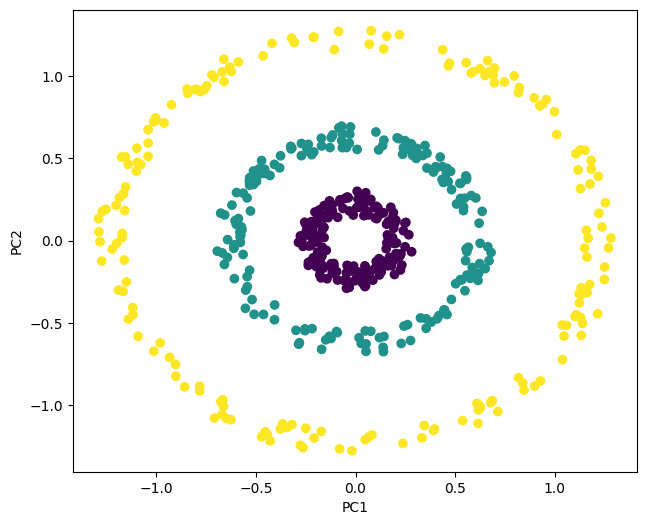

In [ ]:
print(K_circles)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(circles[0], circles[1], c=labels_circles)
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.subplot(1,2,2)
#plt.scatter(range(0,len(eigenvals_circles[:10])), eigenvals_circles[:10])
#plt.ylabel('Eigenvector')
#plt.ylabel('Eigenvalue')
plt.show()

In [ ]:
labels_blobs, K_blobs, D_blobs, eigenvals_blobs, A_blobs = Spectrum(blobs.T, iters = 5, Z=10)

8


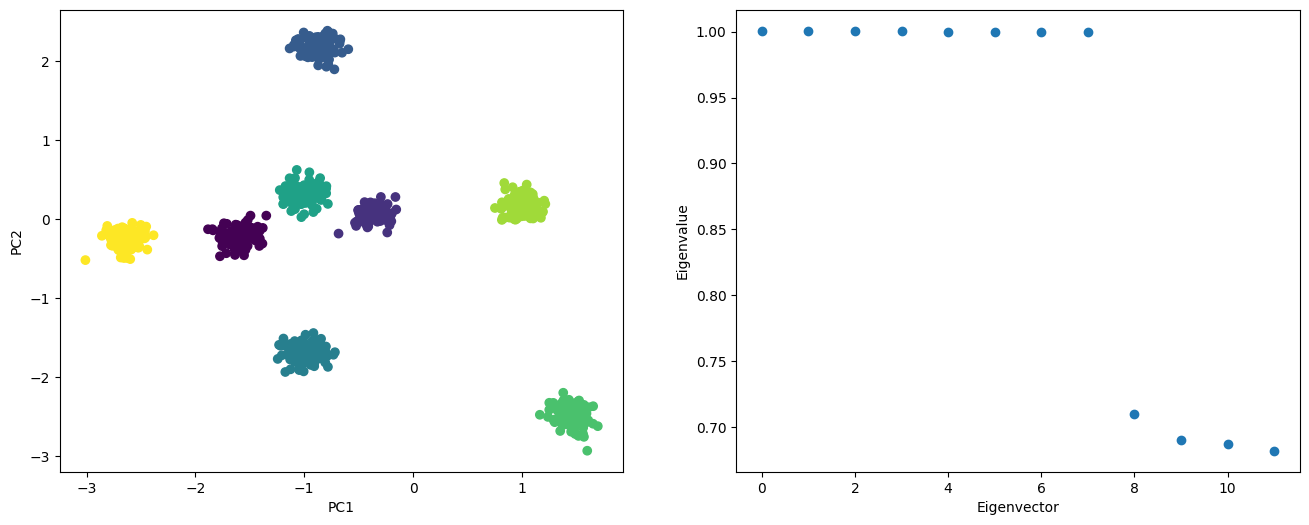

In [ ]:
print(K_blobs)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(blobs[0,:], blobs[1,:], c=labels_blobs)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.subplot(1,2,2)
plt.scatter(range(0,len(eigenvals_blobs[:12])), eigenvals_blobs[:12])
plt.xlabel('Eigenvector')
plt.ylabel('Eigenvalue')
plt.show()

In [ ]:
labels_spirals, K_spirals, D_spirals, eigenvals_spirals, A_spirals = Spectrum(spirals.T, iters = 5, Z=10)

2


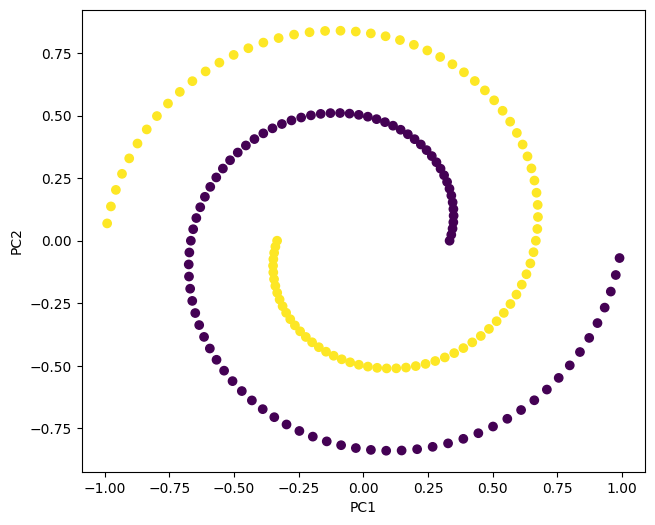

In [ ]:
print(K_spirals)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(spirals[0], spirals[1], c=labels_spirals)
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.subplot(1,2,2)
#plt.scatter(range(0,len(eigenvals_spirals[:10])), eigenvals_spirals[:10])
#plt.ylabel('Eigenvector')
#plt.ylabel('Eigenvalue')
plt.show()

## TGCA datasets

In [ ]:
def run_spectrum_and_plot(data):
  dat_l = []
  for plat in platforms[:3]: dat_l.append(data[plat])
  # Note: due to column selection columns (and rows for clin) are also in the same order
  labels_1, K_1, D_1, eigenvals_1, A_1 = Spectrum(dat_l, iters = 5, Z = 10)
  A_1_normalized = (A_1 - np.min(A_1)) / (np.max(A_1) - np.min(A_1))

  # Convert similarity matrix to distance matrix
  distance_1 = 1 - A_1_normalized

  # Apply UMAP to the distance matrix
  mapper = umap.UMAP(metric='precomputed', random_state = 5).fit(distance_1)
  umap.plot.points(mapper, labels = labels_1,theme="red")
  return (labels_1, K_1, D_1, eigenvals_1, A_1,distance_1)

In [ ]:
from sklearn.model_selection import train_test_split
from sksurv.nonparametric import kaplan_meier_estimator
def plot_survivability(data, labels, labels_nb):
  data.loc[:,"Label"] = labels
  data = data[data["Time"] >= 0]
  data["Death"] = data.loc[:,"Death"].astype(int).astype(bool)

  model = CoxPHSurvivalAnalysis()
  for label in range (labels_nb):
    lab_dat = data[data["Label"] == label]
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        lab_dat["Death"],
        lab_dat["Time"],
        conf_type="log-log",
    )
    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Cluster label = {label}")

  plt.ylim(0, 1)
  plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
  plt.xlabel("time $t$")
  plt.legend(loc="best")
  plt.show()





### BLCA Run

(338, 338)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


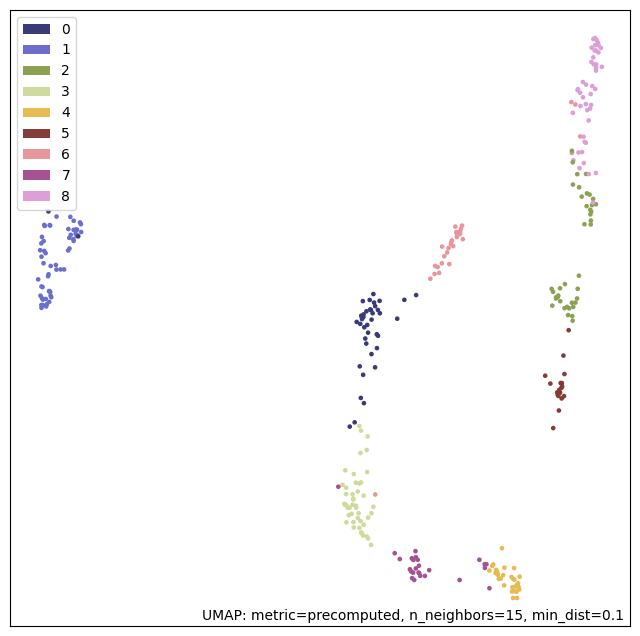

In [ ]:
blca_res = run_spectrum_and_plot(data["BLCA"])

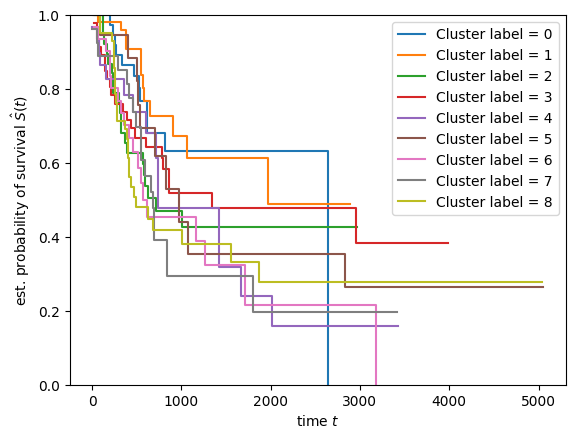

In [ ]:
plot_survivability(data["BLCA"]["clin"], blca_res[0],blca_res[1])

### BRCA run

(634, 634)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


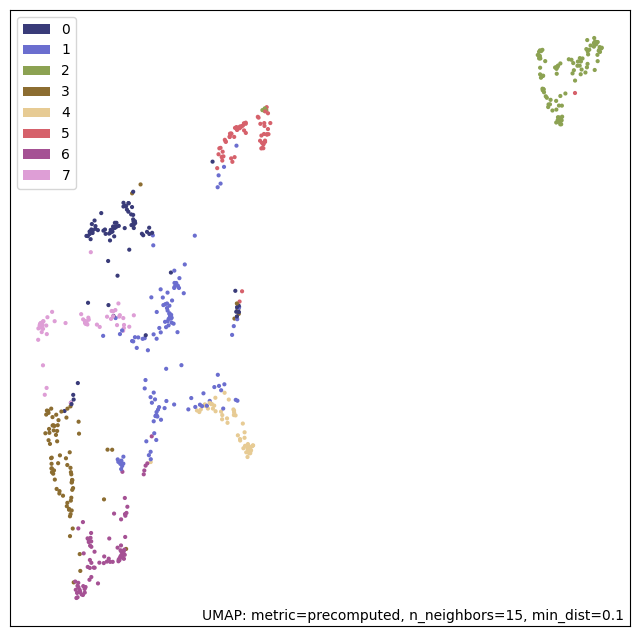

In [ ]:
brca_res = run_spectrum_and_plot(data["BRCA"])

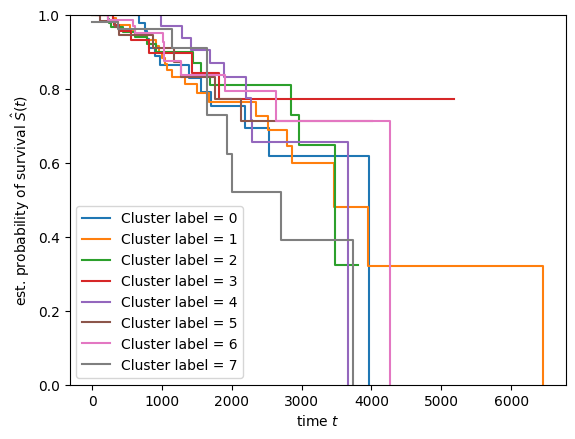

In [ ]:
plot_survivability(data["BRCA"]["clin"], brca_res[0],brca_res[1])

### KIRC Run

(237, 237)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


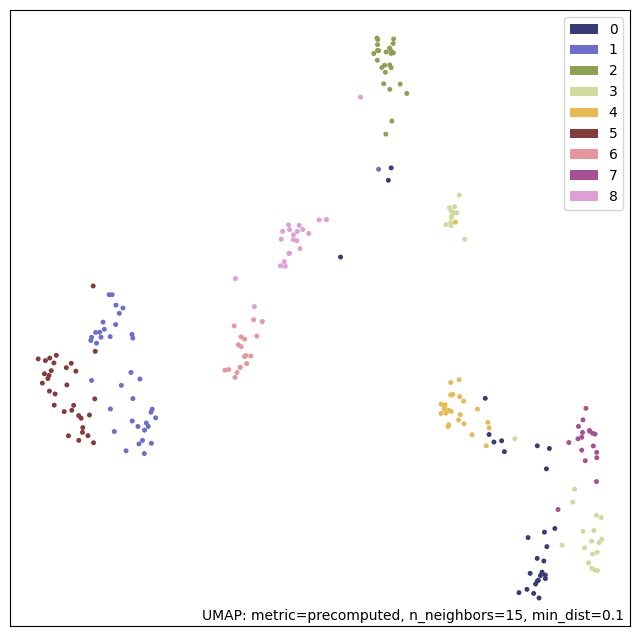

In [ ]:
kirc_res = run_spectrum_and_plot(data["KIRC"])

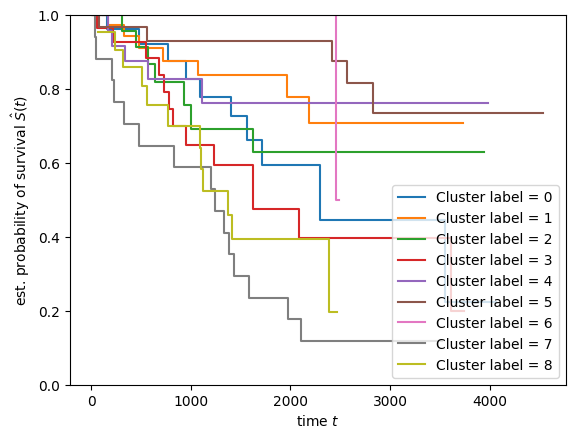

In [ ]:
plot_survivability(data["KIRC"]["clin"], kirc_res[0],kirc_res[1])

### LGG Run

(425, 425)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


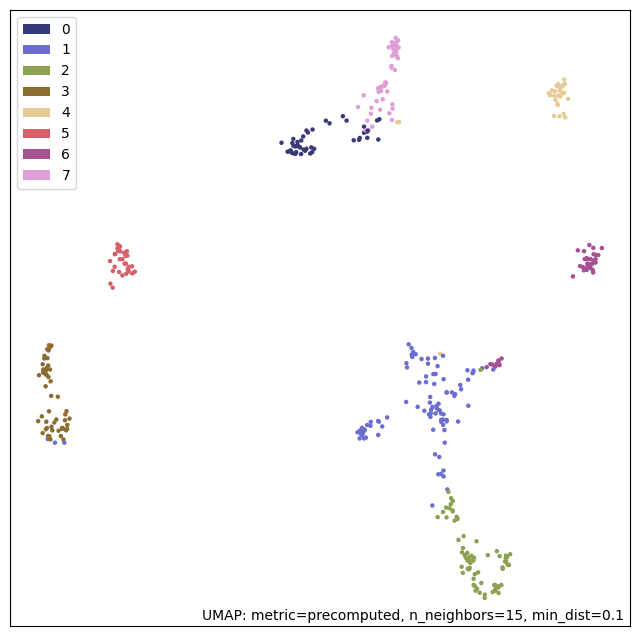

In [ ]:
lgg_res = run_spectrum_and_plot(data["LGG"])

<ipython-input-119-83615f27dc95>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Death"] = data.loc[:,"Death"].astype(int).astype(bool)


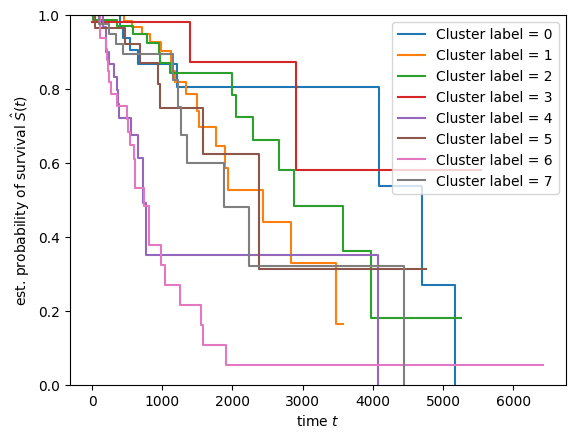

In [ ]:
plot_survivability(data["LGG"]["clin"], lgg_res[0],lgg_res[1])

### PCPG run

(80, 80)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


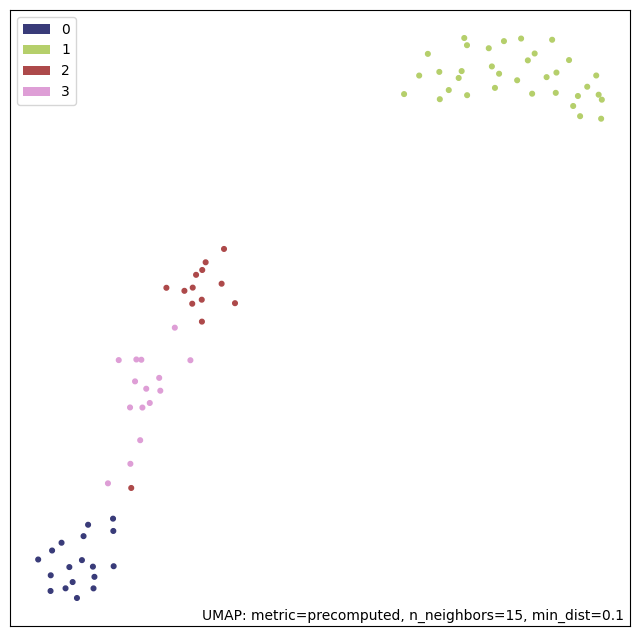

In [ ]:
pcpg_res = run_spectrum_and_plot(data["PCPG"])

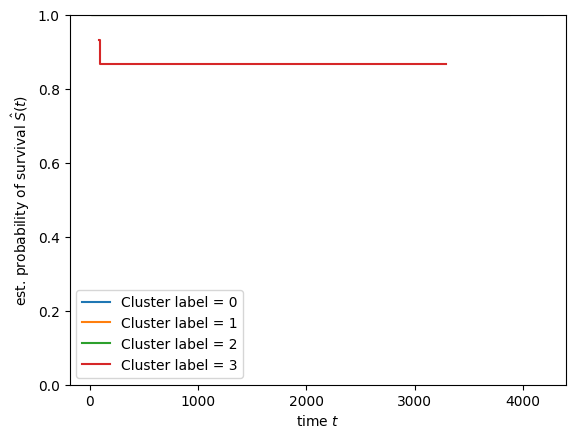

In [ ]:
plot_survivability(data["PCPG"]["clin"], pcpg_res[0],pcpg_res[1])

SKCM Run

(338, 338)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


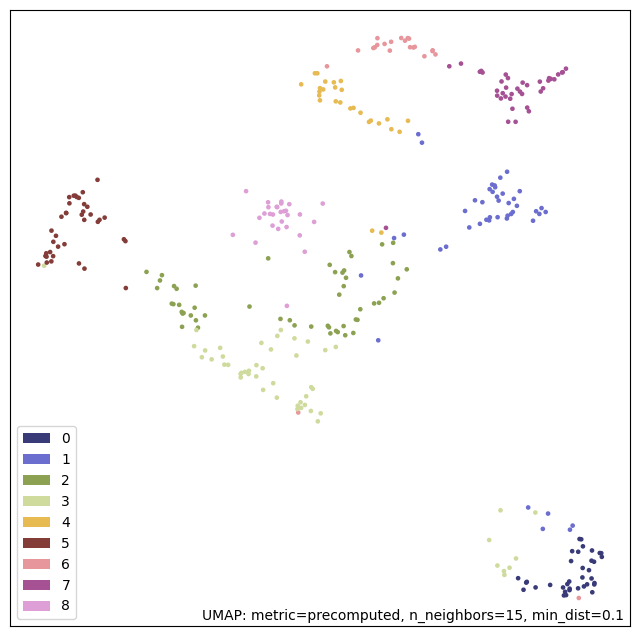

In [ ]:
skcm_res = run_spectrum_and_plot(data["SKCM"])

<ipython-input-119-83615f27dc95>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Death"] = data.loc[:,"Death"].astype(int).astype(bool)


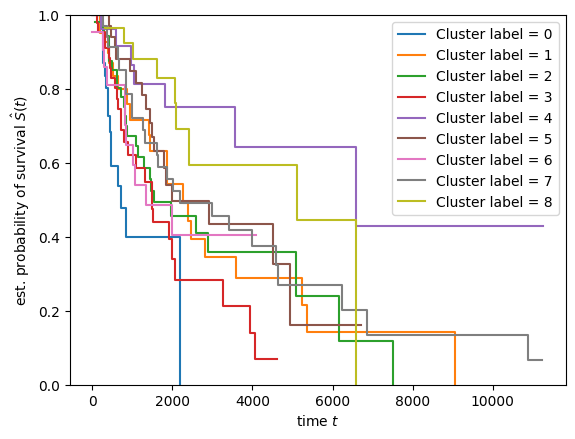

In [ ]:
plot_survivability(data["SKCM"]["clin"], skcm_res[0],skcm_res[1])

### THCA Run

(219, 219)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


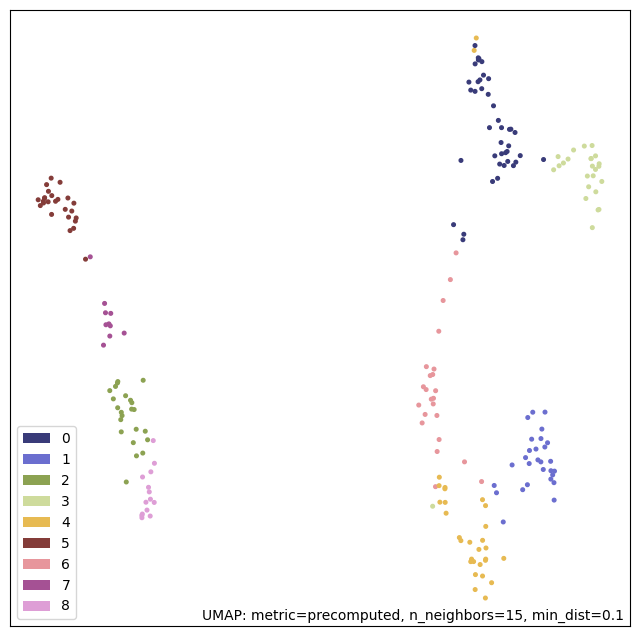

In [ ]:
thca_res = run_spectrum_and_plot(data["THCA"])

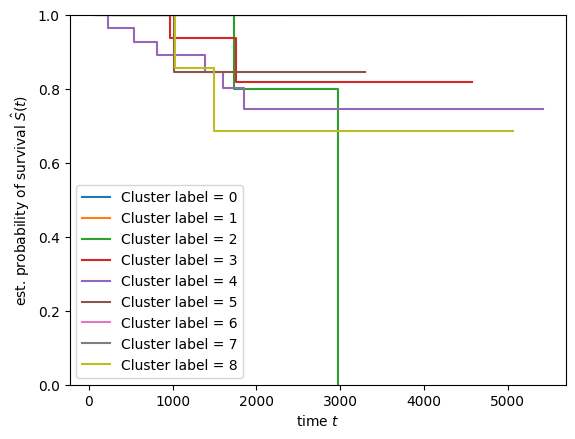

In [ ]:
plot_survivability(data["THCA"]["clin"], thca_res[0],thca_res[1])

## Runtime analysis

### Circles

In [ ]:
num_iterations = 100

# Initialize a list to store the elapsed time for each iteration
times = np.empty(100)

# Loop through 100 iterations, timing each
for i in range(num_iterations):
    start_time = time.time()
    labels_circles, K_circles, D_circles, eigenvals_circles, A_circles = Spectrum(circles.T, iters=5, Z=10)
    end_time = time.time()

    elapsed_time = end_time - start_time
    times[i] = elapsed_time

# Calculate the average elapsed time
average_time = np.mean(times)

print(average_time)

### Blobs

In [ ]:
num_iterations = 100

# Initialize a list to store the elapsed time for each iteration
times = np.empty(100)

# Loop through 100 iterations, timing each
for i in range(num_iterations):
    start_time = time.time()
    labels_blobs, K_blobs, D_blobs, eigenvals_blobs, A_blobs = Spectrum(blobs.T, iters = 5, Z=10)
    end_time = time.time()

    elapsed_time = end_time - start_time
    times[i] = elapsed_time

# Calculate the average elapsed time
average_time = np.mean(times)

print(average_time)

### Spirals

In [ ]:
num_iterations = 100

# Initialize a list to store the elapsed time for each iteration
times = np.empty(100)

# Loop through 100 iterations, timing each
for i in range(num_iterations):
    start_time = time.time()
    labels_spirals, K_spirals, D_spirals, eigenvals_spirals, A_spirals = Spectrum(spirals.T, iters = 5, Z=10)
    end_time = time.time()


    elapsed_time = end_time - start_time
    times[i] = elapsed_time

# Calculate the average elapsed time
average_time = np.mean(times)

print(average_time)